In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

keras = tf.keras

# import tensorflow as tf
# from tensorflow.keras import layers
from tensorflow import keras
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1500)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import tensorflow as tf

from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tqdm import tqdm_notebook


In [10]:
# from tensorflow import keras as k1
# import keras as k2

In [11]:
# print(k1)
# print(k2)
# <module 'tensorflow.keras' from '/usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/api/_v2/keras/__init__.py'>
# <module 'keras' from '/usr/local/lib/python3.5/dist-packages/keras/__init__.py'>

<module 'tensorflow.keras' from '/usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/api/_v2/keras/__init__.py'>
<module 'keras' from '/usr/local/lib/python3.5/dist-packages/keras/__init__.py'>


In [2]:
# 1. 数据预处理
# 1.1. 下载数据
# import tensorflow_datasets as tfds


In [3]:
# !pip install tensorflow_datasets -i https://pypi.douban.com/simple

In [4]:
# !pip install protobuf -U -i https://pypi.douban.com/simple

In [5]:
# tfds.load方法下载并缓存数据，并返回tf.data.Dataset对象，这些对象提供了强大、高效的方法来处理数据并将其传递到模型中。

# 由于"cats_vs_dog" 没有定义标准分割，因此使用subsplit功能将其分为训练80%、验证10%、测试10%的数据。

In [6]:
# SPLIT_WEIGHTS = (8, 1, 1)
# splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

# (raw_train, raw_validation, raw_test), metadata = tfds.load(
#     'cats_vs_dogs', split=list(splits),
#     with_info=True, as_supervised=True)

In [7]:
# # 生成的tf.data.Dataset对象包含（图像，标签）对。图像具有可变形状和3个通道，标签是标量
# print(raw_train)
# print(raw_validation)
# print(raw_test)

In [8]:
######不好下载就先人工下载，然后读取就可以了


In [7]:
import pathlib

In [8]:
data_root = pathlib.Path('data')
print(data_root)

data


In [9]:
import random
#读取文档下的所有路径，直接用正则表达式不需要遍历目录就可以了
all_image_paths = list(data_root.glob('train/*.jpg'))
# print(all_image_paths[:20])
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths=all_image_paths#[:5000]####取前5000条测试
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

25000

In [10]:
label_names=[ 'cat' if 'cat' in each else 'dog'  for each in all_image_paths ]

In [11]:
all_image_labels=[0 if 'cat' in each else 1 for each in label_names]

In [12]:
all_image_labels[:50]

[0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0]

In [13]:
# Wrap up these up in simple functions for later.
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

In [14]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

In [15]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [16]:
# Now create a new dataset that loads and formats images on the fly by mapping preprocess_image over the dataset of paths.
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=2)

In [17]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [18]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [19]:
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [20]:
BUFFER_SIZE = 1000
BATCH_SIZE = 8
TAKE_SIZE = 5000

In [21]:

####构造整块作为训练集，batch
# # Setting a shuffle buffer size as large as the dataset ensures that the data is
# # completely shuffled.
# ds = image_label_ds.shuffle(buffer_size=image_count)
# ds = ds.repeat()
# ds = ds.batch(BATCH_SIZE)
# # `prefetch` lets the dataset fetch batches in the background while the model is training.
# ds = ds.prefetch(buffer_size=4)
# ds

In [22]:
#This mobile_net model expects its input to be normalized to the [-1,1] range:

In [23]:
ds=image_label_ds
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)

In [24]:
keras_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>

In [25]:
# Use tf.data.Dataset.take and tf.data.Dataset.skip to create a small test dataset and a larger training set.


In [26]:
##取skip之后的数据
train=keras_ds.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)
validation=keras_ds.take(TAKE_SIZE)
test=keras_ds.take(TAKE_SIZE)

In [27]:
train

<ShuffleDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>

In [28]:
validation

<TakeDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>

In [29]:
train_batches = train.batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [30]:
train_batches

<BatchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>

In [31]:
train_batches.take(5)

<TakeDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>

In [32]:
# Inspect a batch of data:

In [33]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([8, 192, 192, 3])

In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np


In [15]:
base_model = Xception(weights='imagenet')
# base_model.load_weights('../input/keras-pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [5]:
model = ResNet50(weights='imagenet')

    90112/102853048 [..............................] - ETA: 9:33:59

KeyboardInterrupt: 

In [35]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(8, 6, 6, 1280)


In [36]:
# Feature extraction
# You will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.
# Freeze the convolutional base
# It's important to freeze the convolutional based before you compile and train the model. By freezing (or setting layer.trainable = False), you prevent the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.


In [37]:
base_model.trainable = False

In [38]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 193, 193, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 96, 96, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 96, 96, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

block_15_project_BN (BatchNorma (None, 6, 6, 160)    640         block_15_project[0][0]           
__________________________________________________________________________________________________
block_15_add (Add)              (None, 6, 6, 160)    0           block_14_add[0][0]               
                                                                 block_15_project_BN[0][0]        
__________________________________________________________________________________________________
block_16_expand (Conv2D)        (None, 6, 6, 960)    153600      block_15_add[0][0]               
__________________________________________________________________________________________________
block_16_expand_BN (BatchNormal (None, 6, 6, 960)    3840        block_16_expand[0][0]            
__________________________________________________________________________________________________
block_16_expand_relu (ReLU)     (None, 6, 6, 960)    0           block_16_expand_BN[0][0]         
__________

In [32]:
# Add a classification head
# To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.


In [39]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(8, 1280)


In [40]:
# Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [41]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(8, 1)


In [42]:
# Now stack the feature extractor, and these two layers using a tf.keras.Sequential model:

In [43]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [44]:
# Compile the model
# # You must compile the model before training it. Since there are two classes, use a binary cross-entropy loss.

In [45]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [47]:
len(model.trainable_variables)

2

In [42]:
# Train the model
# # After training for 10 epochs, you should see ~96% accuracy.

In [48]:
num_train, num_val, num_test=(20000,5000,5000)

In [49]:
initial_epochs = 5
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 4s 194ms/step - loss: 5.8623 - accuracy: 0.5500


In [45]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 5.68
initial accuracy: 0.47


In [50]:
# tf.keras.backend.set_learning_phase(True)###不知是加大batchsize（是batch_size太小的原因造成的,有时似乎又没有问题）原因还是加了backend原因
##batchsize=16时达到0.98,；8时仅仅为0.95
##通常加大batchsize能够加大效果（），tf.keras.backend.set_learning_phase(True)能够加快训练时的收敛速度


history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/5


W0723 08:15:54.347526 140684064118528 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2500/2500 [==============================] - 180s 72ms/step - loss: 1.3878 - accuracy: 0.8157 - val_loss: 0.6715 - val_accuracy: 0.9212
Epoch 2/5
2500/2500 [==============================] - 176s 70ms/step - loss: 0.8693 - accuracy: 0.8929 - val_loss: 0.6197 - val_accuracy: 0.9284
Epoch 3/5
2500/2500 [==============================] - 183s 73ms/step - loss: 0.7968 - accuracy: 0.9048 - val_loss: 0.4427 - val_accuracy: 0.9486
Epoch 4/5
2500/2500 [==============================] - 176s 70ms/step - loss: 0.7583 - accuracy: 0.9101 - val_loss: 0.5235 - val_accuracy: 0.9428
Epoch 5/5
2500/2500 [==============================] - 176s 70ms/step - loss: 0.7355 - accuracy: 0.9136 - val_loss: 0.4119 - val_accuracy: 0.9532


In [ ]:
# Learning curves
# Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

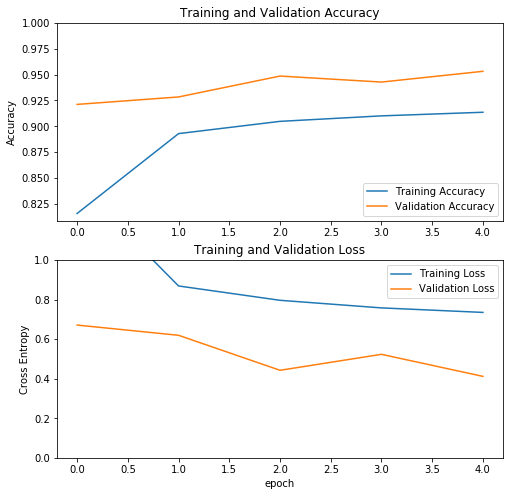

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [50]:
# Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

In [51]:
# Fine tuning
# In our feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training.

In [52]:
# Un-freeze the top layers of the model
# All you need to do is unfreeze the base_model and set the bottom layers be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [52]:
base_model.trainable = True

In [53]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [54]:
# Compile the model
# Compile the model using a much lower training rate.

In [55]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [57]:
len(model.trainable_variables)

58

In [58]:
# Continue Train the model
# If you trained to convergence earlier, this will get you a few percent more accuracy.

In [59]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = initial_epochs,
                         validation_data=validation_batches)

Epoch 6/10
2500/2500 [==============================] - 307s 123ms/step - loss: 0.6689 - accuracy: 0.9240 - val_loss: 0.1944 - val_accuracy: 0.9740
Epoch 7/10
2500/2500 [==============================] - 281s 112ms/step - loss: 0.5236 - accuracy: 0.9566 - val_loss: 0.1814 - val_accuracy: 0.9776
Epoch 8/10
2500/2500 [==============================] - 279s 112ms/step - loss: 0.4597 - accuracy: 0.9667 - val_loss: 0.1796 - val_accuracy: 0.9784
Epoch 9/10
2500/2500 [==============================] - 280s 112ms/step - loss: 0.4205 - accuracy: 0.9707 - val_loss: 0.1696 - val_accuracy: 0.9776
Epoch 10/10
2500/2500 [==============================] - 279s 112ms/step - loss: 0.3937 - accuracy: 0.9732 - val_loss: 0.1680 - val_accuracy: 0.9794


In [60]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

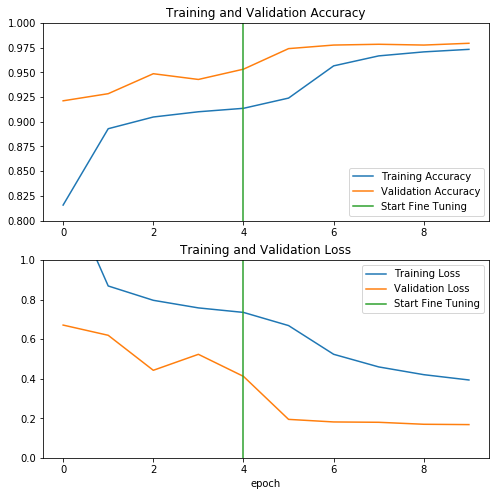

In [61]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()